<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/mec647_Fracture_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

try:
    import pyvista
except ImportError:
    !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML
# !pip install --ignore-installed PyYAML



In [10]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML
# !pip install --ignore-installed PyYAML



# Fracture


Let $\Omega \subset (0, L)^D$, with $D=1, 2, 3$, $L$ finite, being the (or one) characteristic length of the specimen.
For any 
- displacement field $u\in V_t : H^1(\Omega, R^n) + bcs(t)$ with $n=1, 2$ or $3$, and
- damage field $\alpha \in H^1(\Omega, R)$,

consider the energy $E(u, \alpha)$ defined as
$$
E_\ell(u, \alpha)=\frac{1}{2}\int_\Omega a(\alpha) W(u) dx + \underbrace{\frac{G_c}{c_w} \int \left(\frac{1}{\ell}w(\alpha) + \ell |\nabla \alpha|^2 \right)dx}_{\text{Surface energy}}- \int_\Omega f.u dx$$

In practice, $\ell \ll L$.

Above, $W$ is the elastic energy density, reading (in linearised elasticity as) 
$$ 
W(u) = Ae(u):e(u)
$$
where $A$ is the 4-th order tensor of elasticity, in the isotropic and homogeneous case, it corresponds to a linear combination with two coefficients, say, $A_0$ the stiffness (dimensional), and $\nu$ the Poisson ratio (non-dimensional). 


Further, $w(\alpha)$ corresponds to the dissipated energy to damage, homogeneously, the specimen, the gradient term accounts for spatial variations.

**Keypoint:** these two terms are weighted by $\ell$, a parameter that is homogeneous to a length and is understood as a *material* quantity (as opposed to *numerical*).

Define $D(\alpha_0):=\left\{ \alpha \in H^1(\Omega), \alpha \geq \alpha_0 \right\}$, for some $\alpha_0(x)\geq 0$ pointwise. 

We solve two types of problems (by increasing difficulty):
- **The static problem**: Given a load (boundary conditions) and an initial state of damage $\alpha_0$, what is the equilibrium displacement and repartition of damage?
In other terms:
 
$
\text{ min loc} \left\{ E_\ell(u, \alpha):
 u \in V_t, \alpha \in D(\alpha_0) \right\}.
$

- **The evolution problem**: Given a load **history** (boundary conditions as a function of $t$) and an initial state of damage $\alpha_0$, what is the *evolution* of equilibrium displacement and repartition of damage, i.e. 
the map $t\mapsto (u_t, \alpha_t)$, such that 
  - (Irrevers.) $\alpha_t \nearrow t$,
  - (Stability) $(u_t, \alpha_t) = \operatorname{arg loc min} \left\{ E_\ell (v, \beta), (v, \beta) \in V_t \times D(\alpha_t) \right\}$  -->



### Parameters

In the energy above:
- Two elasticity parameters, such as
  - $A_0$ the stiffness of the sound material
  - $\nu$ the Poisson ratio
  - equivalently, $\mu, \lambda$ the Lamé parameters
- Two fracture/damage parameters:
  - $\ell$ the internal damage length
  - $G_c$ the material toughness


### Back of the envelope computation.

1. Show that the energy above can be written as a function of only two non-dimensional parameters (ex.: $\nu, \tilde \ell)$, by dimensional analysis.

In [11]:
branch_name = 'main'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
except Exception:
  print('Something went wrong')
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git


Cloning into 'mec647'...
remote: Enumerating objects: 684, done.
remote: Counting objects: 100% (684/684), done.
remote: Compressing objects: 100% (559/559), done.
remote: Total 684 (delta 305), reused 303 (delta 106), pack-reused 0
Receiving objects: 100% (684/684), 12.63 MiB | 17.62 MiB/s, done.
Resolving deltas: 100% (305/305), done.


In [12]:
sys.path.append('mec647/')


In [31]:
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD

from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)

# meshes
import meshes
from meshes import primitives

In [70]:
# Parameters

parameters = {
    'loading': {
        'min': 0,
        'max': 1.5,
        'steps': 10
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 1.,
        'Ly': 0.1
    },
    'model': {
        'E': 1.,
        'nu': 0.,
        'w1': 1.,
        'ell': 0.05,
        'k_res': 1.e-8
    },
    'solvers': {
          'elasticity': {        
            'snes': {
                'snes_type': 'newtontr',
                'snes_stol': 1e-8,
                'snes_atol': 1e-8,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        },
          'damage': {        
            'snes': {
                'snes_type': 'vinewtonrsls',
                'snes_stol': 1e-5,
                'snes_atol': 1e-5,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            },
        },
          'damage_elasticity': {
            "max_it": 100,
            "alpha_rtol": 1.0e-5,
            "criterion": "alpha_H1"
          }
    }
}

In [48]:
# Equivalently
import yaml

with open("mec647/test/parameters.yml") as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)


In [49]:
parameters.get("model").get("ell")

0.1

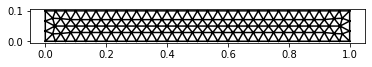

In [50]:
# Mesh

Lx = parameters["geometry"]["Lx"]
Ly = parameters["geometry"]["Ly"]
geom_type = parameters["geometry"]["geom_type"]

gmsh_model, tdim = primitives.mesh_bar_gmshapi(geom_type,
                                    Lx, 
                                    Ly, 
                                    parameters.get("model").get("ell")/3, 
                                    tdim=2)

mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)


from utils.viz import plot_mesh

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")


In [71]:
# Functional Setting

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)

element_alpha = ufl.FiniteElement("Lagrange", mesh.ufl_cell(),
                              degree=1)

V_u = dolfinx.fem.FunctionSpace(mesh, element_u) 
V_alpha = dolfinx.fem.FunctionSpace(mesh, element_alpha) 

u = dolfinx.fem.Function(V_u, name="Displacement")
u_ = dolfinx.fem.Function(V_u, name="BoundaryDisplacement")


alpha = dolfinx.fem.Function(V_alpha, name="Damage")

# Pack state
state = {"u": u, "alpha": alpha}

# Bounds
alpha_ub = dolfinx.fem.Function(V_alpha, name="UpperBoundDamage")
alpha_lb = dolfinx.fem.Function(V_alpha, name="LowerBoundDamage")



dx = ufl.Measure("dx", domain = mesh)
ds = ufl.Measure("ds", domain = mesh)

In [72]:
# Boundary sets

dofs_alpha_left = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], 0.))
dofs_alpha_right = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], Lx))

dofs_u_left = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], 0.))
dofs_u_right = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], Lx))

In [73]:
# Boundary data

u_.interpolate(lambda x: (np.ones_like(x[0]), np.zeros_like(x[1])))

# Bounds (nontrivial)

alpha_lb.interpolate(lambda x: np.zeros_like(x[0]))
alpha_ub.interpolate(lambda x: np.ones_like(x[0]))

In [74]:
# Boundary conditions

bcs_u = [
         dirichletbc(np.array([0., 0.], dtype=PETSc.ScalarType),
                      dofs_u_left,
                      V_u),
         dirichletbc(u_, dofs_u_right)
         ]

bcs_alpha = [
             dirichletbc(np.array(0., dtype = PETSc.ScalarType),
                         np.concatenate([dofs_alpha_left, dofs_alpha_right]),
                         V_alpha)
]


In [75]:
import models
from models import DamageElasticityModel as Brittle

In [76]:
bcs = {"bcs_u": bcs_u, "bcs_alpha": bcs_alpha}

model = Brittle(parameters["model"])


total_energy = model.total_energy_density(state) * dx

In [77]:
import algorithms
from algorithms import am

In [78]:
solver = am.AlternateMinimisation(total_energy,
                         state,
                         bcs,
                         parameters.get("solvers"),
                         bounds=(alpha_lb, alpha_ub)
                         )

In [79]:
# Loop for evolution


loads = np.linspace(parameters.get("loading").get("min"),
                    parameters.get("loading").get("max"),
                    parameters.get("loading").get("steps"))

data = {
    'elastic': [],
    'surface': [],
    'total': [],
    'load': []
}
for (i_t, t) in enumerate(loads):
  # update boundary conditions

  u_.interpolate(lambda x: (t * np.ones_like(x[0]), np.zeros_like(x[1])))
  u_.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # update lower bound for damage
  alpha.vector.copy(alpha_lb.vector)
  alpha.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # solve for current load step
  print(f"Solving timestep {i_t}, load: {t}")

  solver.solve()

  # postprocessing
  # global

  surface_energy = comm.allreduce(
          assemble_scalar(
            dolfinx.fem.form(model.damage_dissipation_density(state) * dx)),
          op=MPI.SUM
          )

  elastic_energy = comm.allreduce(
      assemble_scalar(
        dolfinx.fem.form(model.elastic_energy_density(state) * dx)),
          op=MPI.SUM
        )
  
  data.get('elastic').append(elastic_energy)
  data.get('surface').append(surface_energy)
  data.get('total').append(surface_energy+elastic_energy)
  data.get('load').append(t)

  print(f"Solved timestep {i_t}, load: {t}")
  print(f"Elastic Energy {elastic_energy:.3g}, Surface energy: {surface_energy:.3g}")
  print("\n\n")

  # savings?








Solving timestep 0, load: 0.0
  0 SNES Function norm 0.000000000000e+00 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 0, load: 0.0
Elastic Energy 0, Surface energy: 0



Solving timestep 1, load: 0.16666666666666666
  0 SNES Function norm 4.550226413810e-01 
  1 SNES Function norm 3.796504297722e-01 
  2 SNES Function norm 2.289060065546e-01 
  3 SNES Function norm 2.919139040773e-16 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 1, load: 0.16666666666666666
Elastic Energy 0.00139, Surface energy: 0



Solving timestep 2, load: 0.3333333333333333
  0 SNES Function norm 4.550226413810e-01 
  1 SNES Function norm 3.640181131048e-01 
  2 SNES Function norm 1.820090565524e-01 
  3 SNES Function norm 3.234800395702e-16 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 2, load: 0.3333333333333333
Elastic Energy 0.00556, Surface energy: 0



Solving timestep 3, load: 0.5
  0 SNES Function norm 4.550226413810e-01 
  1 SNES Function norm 2.730135848286e-01 


([<matplotlib.axis.XTick at 0x7f1e2c2d4790>,
 [Text(0, 0, '0'), Text(0, 0, '1')])

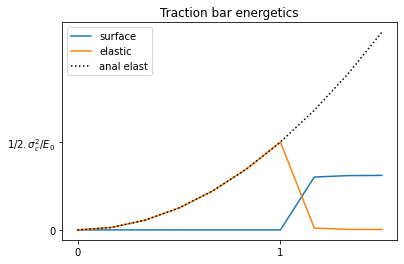

In [80]:
plt.plot(data.get('load'), data.get('surface'), label='surface')
plt.plot(data.get('load'), data.get('elastic'), label='elastic')
plt.plot(data.get('load'), [1./2. * t**2*Ly for t in data.get('load')], label='anal elast', ls=':', c='k')

plt.title('Traction bar energetics')
plt.legend()
plt.yticks([0, 1/20], [0, '$1/2.\sigma_c^2/E_0$'])
plt.xticks([0, 1], [0, 1])

In [ ]:
# experiments
params0, data0 = parameters, data


In [ ]:
from test_viz import plot_vector, plot_scalar, plot_profile

_ell = parameters.get('model').get('ell')
tol = 1e-3
xs = np.linspace(0 + tol, Lx - tol, 101)
points = np.zeros((3, 101))
points[0] = xs

_plt, data = plot_profile(
    alpha,
    points,
    subplot=(0, 0),
    lineproperties={
        "c": "k",
        "label": f"$alpha$ with $\ell$ = {_ell:.2f}"
    },
)
ax = _plt.gca()
ax.axvline(0.0, c="k")
ax.axvline(2 * _ell, c="k", label='D=$2\ell$')
_plt.legend()
_plt.fill_between(data[0], data[1].reshape(len(data[1])))
_plt.title("Traction bar damage profile")
